<a href="https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_python_cn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 进行模型推理

MMClassification 提供了 high level 的 Python API 用来进行推理计算. 

首先，我们构建模型。

In [22]:
import mmcv
from mmcls.apis import inference_model, init_model, show_result_pyplot

# 指明设备，如果你没有开启 GPU，可以使用 CPU， `device='cpu'`.
device = 'cuda:0'
# device = 'cpu'
# 通过配置文件和权重参数文件构建模型
model = init_model(config_file, checkpoint_file, device=device)

/usr/local/lib/python3.7/dist-packages/mmcv/cnn/bricks/transformer.py:28: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/lib/python3.7/dist-packages/yaml/constructor.py:126: DeprecationWarni

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmclassification/v0/mobilenet_v2/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2_batch256_imagenet_20200708-3b2dc3af.pth


  0%|          | 0.00/13.5M [00:00<?, ?B/s]

/content/mmclassification/mmcls/apis/inference.py:44: UserWarning: Class names are not saved in the checkpoint's meta data, use imagenet by default.
  warnings.warn('Class names are not saved in the checkpoint\'s '


In [23]:
# 模型的继承关系
model.__class__.__mro__

(mmcls.models.classifiers.image.ImageClassifier,
 mmcls.models.classifiers.base.BaseClassifier,
 mmcv.runner.base_module.BaseModule,
 torch.nn.modules.module.Module,
 object)

In [24]:
# 在单张图片上展示模型的分类效果
img = 'demo/banana.png'
img_array =  mmcv.imread(img)
result = inference_model(model, img_array)
result

{'pred_class': 'banana', 'pred_label': 954, 'pred_score': 0.9999284744262695}

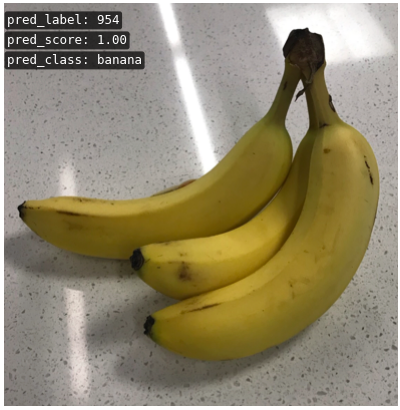

In [25]:
%matplotlib inline
# 可视化分类结果
show_result_pyplot(model, img, result)

## 使用 Python API 进行模型微调

模型微调是将预训练好的模型在特定的数据集上对模型参数进行非常精细调整的过程，最终让预训练的模型能够适配新的数据集及对应的任务。相比于模型的训练过程，模型微调大大降低了训练的时间，并减少了数据量很小的数据集在训练过程中会出现的过拟合问题。

模型微调的基本步骤如下：

1. 准备新数据集并满足 MMClassification 的要求
2. 根据数据集修改训练配置 
3. 进行训练和验证

更多细节可以查看 [文档](https://mmclassification.readthedocs.io/zh_CN/latest/tutorials/finetune.html).

### 准备数据集并满足 MMClassification 的要求

这里我们下载猫狗分类数据集，关于数据集格式的详细介绍参考 [tools 教程](https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_tools_cn.ipynb)

### 读取配置文件并进行修改

在 [tools 教程](https://colab.research.google.com/github/open-mmlab/mmclassification/blob/master/docs_zh-CN/tutorials/MMClassification_tools_cn.ipynb) 中，我们详细介绍了模型微调所需要修改的各部分配置文件，这里我们可以以 Python 代码的方式修改基础配置文件如下：

In [1]:
# 载入已经存在的配置文件
from mmcv import Config
config_file = 'ddsm_resnet_config.py'
checkpoint_file = 'checkpoints/resnext50_32x4d_b32x8_imagenet_20210429-56066e27.pth'
cfg = Config.fromfile(config_file)

# 修改模型分类头中的类别数目
cfg.model.head.num_classes = 3
cfg.model.head.topk = (1, )

# 加载预训练权重
cfg.model.backbone.init_cfg = dict(type='Pretrained', checkpoint=checkpoint_file, prefix='backbone')

# 根据你的电脑情况设置 sample size 和 workers 
cfg.data.samples_per_gpu = 16
cfg.data.workers_per_gpu = 6

# 指定训练集路径
cfg.data.train.data_prefix = '/home/xumingjie/dataset/patch_set/img_dir/train'
cfg.data.train.ann_file = '/home/xumingjie/dataset/patch_set/img_dir/train_meta.csv'
cfg.data.train.classes = ('bkg','calc','mass')

# 指定验证集路径
cfg.data.val.data_prefix = '/home/xumingjie/dataset/patch_set/img_dir/test'
cfg.data.val.ann_file = '/home/xumingjie/dataset/patch_set/img_dir/test_meta.csv'
cfg.data.val.classes = ('bkg','calc','mass')

# 指定测试集路径
cfg.data.test.data_prefix = '/home/xumingjie/dataset/patch_set/img_dir/test'
cfg.data.test.ann_file = '/home/xumingjie/dataset/patch_set/img_dir/test_meta.csv'
cfg.data.test.classes = ('bkg','calc','mass')

# 设定数据集归一化参数
normalize_cfg = dict(type='Normalize', mean=[124.508, 116.050, 106.438], std=[58.577, 57.310, 57.437], to_rgb=True)
cfg.data.train.pipeline[3] = normalize_cfg
cfg.data.val.pipeline[3] = normalize_cfg
cfg.data.test.pipeline[3] = normalize_cfg

# 修改评价指标选项
cfg.evaluation['metric_options']={'topk': (1, )}

# 设置优化器
cfg.optimizer = dict(type='SGD', lr=0.005, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)

# 设置学习率策略
cfg.lr_config = dict(policy='step', step=5, gamma=0.1)
cfg.runner = dict(type='EpochBasedRunner', max_epochs=100)

# 设置工作目录以保存模型和日志
cfg.work_dir = './work_dirs/ddsm_patch_resxnet'

# 设置每 10 个训练批次输出一次日志
cfg.log_config.interval = 10

# 设置随机种子，并启用 cudnn 确定性选项以保证结果的可重复性
from mmcls.apis import set_random_seed
cfg.seed = 0
set_random_seed(0, deterministic=True)

cfg.gpu_ids = range(1)

/home/xumingjie/anaconda3/envs/open-mmlab/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/xumingjie/anaconda3/envs/open-mmlab/lib/python3.10/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755897462/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


No CUDA runtime is found, using CUDA_HOME='/usr'


### Resxnet

In [ ]:
import time
import mmcv
import os.path as osp

from mmcls.datasets import build_dataset
from mmcls.models import build_classifier
from mmcls.apis import train_model

# 创建工作目录
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
# 创建分类器
model = build_classifier(cfg.model)
model.init_weights()
# 创建数据集
datasets = [build_dataset(cfg.data.train)]
# 添加类别属性以方便可视化
model.CLASSES = datasets[0].CLASSES
# 开始微调
train_model(
    model,
    datasets,
    cfg,
    distributed=False,
    validate=True,
    timestamp=time.strftime('%Y%m%d_%H%M%S', time.localtime()),
    meta=dict())

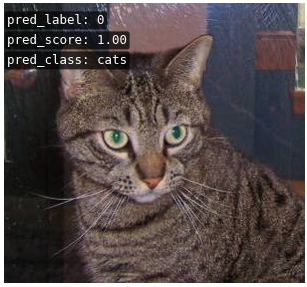

In [34]:
%matplotlib inline
# 验证训练好的模型

img = mmcv.imread('data/cats_dogs_dataset/training_set/training_set/cats/cat.1.jpg')

model.cfg = cfg
result = inference_model(model, img)

show_result_pyplot(model, img, result)